In [1]:
%pylab inline

import os, styles
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import L_sun

Populating the interactive namespace from numpy and matplotlib


In [2]:
def mean_wl(passband):
    return trapz(passband[:,0] * passband[:,1], passband[:,0])/trapz(passband[:,1], passband[:,0])

In [3]:
fname = "data/total_file_z050.dat"
mock_seds = loadtxt(fname)
mock_reds = eval(fname.split(".")[0].split("_")[-1].lstrip("z0"))*0.01

jpas_filters = [file for root, subs, files in os.walk("jpas-filters") for file in files if file.endswith(".res")]
jplus_filters = [file for root, subs, files in os.walk("jplus-filters") for file in files if file.endswith(".res")]

In [4]:
#COMPUTE THE MEAN WAVELENGTH
jpas_wl = array([mean_wl(loadtxt("jpas-filters/{}".format(fname))) for fname in jpas_filters])
jplus_wl = array([mean_wl(loadtxt("jplus-filters/{}".format(fname))) for fname in jplus_filters])
#SORT BY WAVELENGTH
jpas_isort = argsort(jpas_wl)
jplus_isort = argsort(jplus_wl)

In [5]:
#MASK OUT UNUSED JPAS PASSBANDS
jpas_filters = array(jpas_filters)[jpas_isort][:-1]
jpas_wl = jpas_wl[jpas_isort][:-1]
#MASK OUT UNUSED JPLUS PASSBANDS
jplus_filters = array(jplus_filters)[jplus_isort][[1,2,3,4,5,7,8,9,11,13]]
jplus_wl = jplus_wl[jplus_isort][[1,2,3,4,5,7,8,9,11,13]]

In [6]:
#SPLIT SEDs DATA
jpas_indexes = array(range(55), dtype=int)
jplus_indexes = array([59,58,60,61,62,56,63,57,64,65], dtype=int)-1

jpas_fl = mock_seds[0::2,jpas_indexes]
jpas_sg = mock_seds[1::2,jpas_indexes]
jplus_fl = mock_seds[0::2,jplus_indexes]
jplus_sg = mock_seds[1::2,jplus_indexes]

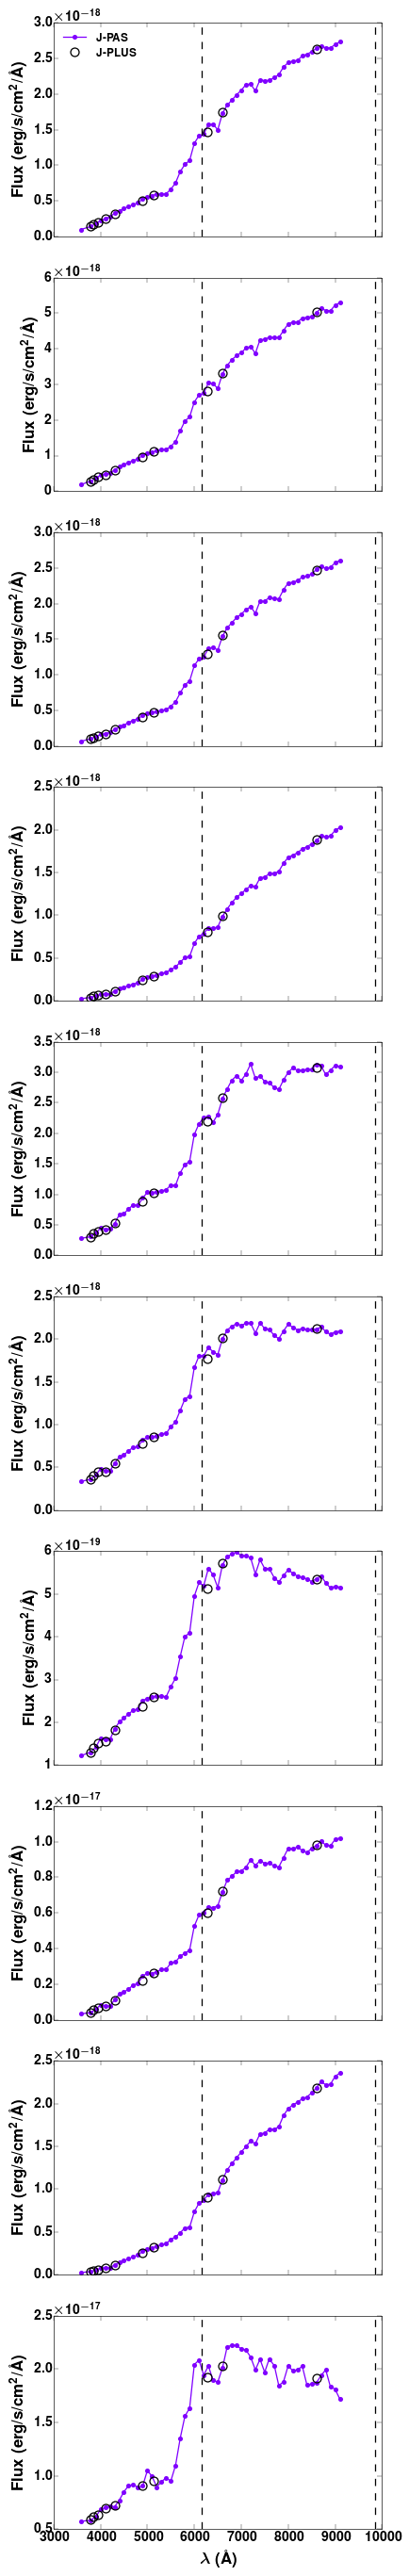

In [7]:
NGAL = jpas_fl.shape[0]
NPLOTS = 10

jpas_mask = ones(55, dtype=bool)
#jpas_mask[[27,28,29,30]] = False
jpas_mask = (jpas_fl>0.0)&(repeat([jpas_mask],jpas_fl.shape[0],axis=0))

jplus_mask = ones(10, dtype=bool)
#jplus_mask[[7,8]] = False
jplus_mask = (jplus_fl>0.0)&(repeat([jplus_mask],jplus_fl.shape[0],axis=0))

distances = FlatLambdaCDM(H0=70, Om0=0.3).luminosity_distance(mock_reds).cgs.value
d_correction = 4*pi*distances*(distances/L_sun.cgs.value)

fig, axs = subplots(NPLOTS, 1, sharex=True, figsize=(5, NPLOTS*3))
for i in range(NPLOTS):
    axs[i].plot(jpas_wl[jpas_mask[i]], jpas_fl[i][jpas_mask[i]], "-o", ms=4, mew=0, label=r"\bf J-PAS")
    axs[i].plot(jplus_wl[jplus_mask[i]], jplus_fl[i][jplus_mask[i]], "o", mfc="none", ms=7, mew=1, label=r"\bf J-PLUS")
    
    axs[i].axvline(6562.80*(mock_reds+1), ls="--", color="k")
    axs[i].axvline(4101.76*(mock_reds+1), ls="--", color="k")
    
    axs[i].set_ylabel(r"\bf Flux (erg/s/cm${}^{2}$/\AA)")

axs[0].legend(loc=0)
axs[i].set_xlabel(r"\bf $\lambda$ (\AA)")

fig.tight_layout()
#fig.savefig("SDSS_sample.png", bbox_inches="tight")

In [8]:
write_sed_files = True
if write_sed_files:
#MASK EMISSION LINES
    jpas_mask = ones(55, dtype=bool)
    #jpas_mask[[27,28,29,30]] = False
    jpas_mask = (jpas_fl>0.0)&(repeat([jpas_mask],jpas_fl.shape[0],axis=0))
    jpas_fl[~jpas_mask] = 0.0
    jpas_sg[~jpas_mask] = 0.0

    jplus_mask = ones(10, dtype=bool)
    #jplus_mask[[7,8]] = False
    jplus_mask = (jplus_fl>0.0)&(repeat([jplus_mask],jplus_fl.shape[0],axis=0))
    jplus_fl[~jplus_mask] = 0.0
    jplus_sg[~jplus_mask] = 0.0
#WRITE SEDs
    fmt = "%8.3f%12.4e%12.4e"
    hdr = "%6s%12s%12s"%tuple("weff flux error".split())
    for i in xrange(NGAL):
        jpas_table = column_stack((jpas_wl, jpas_fl[i]*d_correction, jpas_sg[i]*d_correction))
        jpas_file_sed = open("jpas-z{0}/jpas-z{0}_{1:04d}.txt".format("{0:3.2f}".format(mock_reds).replace(".", "p"), i+1), "w")
        jpas_file_sed.write("# redshift = {0:4.2f}\n".format(mock_reds))
        jpas_file_sed.write("#\n")
        savetxt(jpas_file_sed, jpas_table, fmt=fmt, header=hdr)
        jpas_file_sed.close()

        jplus_table = column_stack((jplus_wl, jplus_fl[i]*d_correction, jplus_sg[i]*d_correction))
        jplus_file_sed = open("jplus-z{0}/jplus-z{0}_{1:04d}.txt".format("{0:3.2f}".format(mock_reds).replace(".", "p"), i+1), "w")
        jplus_file_sed.write("# redshift = {0:4.2f}\n".format(mock_reds))
        jplus_file_sed.write("#\n")
        savetxt(jplus_file_sed, jplus_table, fmt=fmt, header=hdr)
        jplus_file_sed.close()